## Ligand based pharmacophores by clique detection
Clique detection algorithm by [Podolyan and Karypis, 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2631088/)

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True

import numpy as np
import numpy.linalg as LA
import networkx as nx
import networkx.algorithms.isomorphism as iso
import os
import pickle
import matplotlib.pyplot as plt
from itertools import combinations


Bad key "text.kerning_factor" on line 4 in
C:\Users\SRV DATOS\miniconda3\envs\pharmacophore\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Creating the conformers graphs

In [2]:
def bin_distance(distance, bin_size=1):
    """Group distances into bins defined by bin_size"""
    bins = np.arange(21, step=bin_size)
    last_bin = bins[distance > bins][-1]
    
    if distance == last_bin or distance < last_bin + bin_size/2:
        binned_distance = last_bin
    elif distance >= last_bin + bin_size/2:
        binned_distance = last_bin + bin_size

    return binned_distance

def distance_between_pharmacophore_points(p1_coords, p2_coords):
    """Computes the distance between pharmacophore points or edges in a conformer graph"""
    
    vector = p2_coords - p1_coords #vector between the two points
    distance = LA.norm(vector)
    
    return distance

def feature_centroid(molecule, conformer_idx, atom_indxs):
    """Get the 3D coordinates of the centroid of a feature that encompasses
       more than one atom. This could be aromatic, hydrophobic, negative and positive features
    """
    
    n_atoms = len(atom_indxs)
    coords = np.zeros((n_atoms, 3))
    for j, idx in enumerate(atom_indxs):
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(idx)
            coords[j, 0] = position.x
            coords[j, 1] = position.y
            coords[j, 2] = position.z
    
    centroid = coords.mean(axis=0)
   
    return centroid

def get_rdkit_features(molecule, cf_graph, conformer_idx):
    """Load default rdkit features and add them to the graph"""
    
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
    feats = factory.GetFeaturesForMol(molecule)
    
    accepted_feats = ['Acceptor', 'Aromatic', 'Donor', 'Hydrophobe']
    
    i = 0
    for feature in feats:
        feat_name = feature.GetFamily()  
        if feat_name not in accepted_feats:
            continue

        atom_idxs = feature.GetAtomIds()

        if len(atom_idxs) > 1: # it's an aromatic feature!
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        else:
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        
        cf_graph.add_node(i, feat_type=feat_name, coordinates=coords)
        i += 1

def get_smarts_features(molecule, cf_graph, conformer_idx):
    """Load features from a file. Custom features taken from 
        Kutlushina, Alina, Aigul Khakimova, Timur Madzhidov, and Pavel Polishchuk. 
        "Ligand-based pharmacophore modeling using novel 3D pharmacophore signatures." 
        Molecules 23, no. 12 (2018): 3094
    """
    with open('./data/smarts_feats', 'rb') as f:
        feats_dict = pickle.load(f)
    
    i = 0
    for feat, feat_type in feats_dict.items():
        pattern = Chem.MolFromSmarts(feat)  
        atom_idxs = molecule.GetSubstructMatch(pattern)
        if len(atom_idxs) == 0:
            continue
        
        if len(atom_idxs) == 1: # Donor or acceptor feature
            position = molecule.GetConformer(conformer_idx).GetAtomPosition(atom_idxs[0])
            coords = np.zeros((3,))
            coords[0] = position.x
            coords[1] = position.y
            coords[2] = position.z
        else: # Aromatic, hydrophobic, positive or negative feature
            coords = feature_centroid(molecule, conformer_idx, atom_idxs)
        
        cf_graph.add_node(i, feat_type=feat_type, coordinates=coords)
        i += 1

        
def conformer_graph(molecule, conformer_idx, features='rdkit', bin_size=1, min_distance=2, max_distance=13):
    
    cf_graph = nx.Graph()
    
    # Create the graph nodes or pharmacophore points
    if features == 'rdkit':
        get_rdkit_features(molecule, cf_graph, conformer_idx)
    elif features == 'smarts':
        get_smarts_features(molecule, cf_graph, conformer_idx)
    
    # Add edges 
    points = list(cf_graph.nodes())
    points_to_delete = []
    for pi, pj in combinations(points, 2): #combinations between all pharmacophore points
        pi_coords = cf_graph.nodes[pi]['coordinates']
        pj_coords = cf_graph.nodes[pj]['coordinates']
        distance = distance_between_pharmacophore_points(pi_coords, pj_coords)
        if distance < min_distance:
            # Should points that are two close be assigned two labels ?
            # Extract label from pj and add it to the list
            new_label = cf_graph.nodes[pj]['feat_type'] 
            cf_graph.nodes[pi]['feat_type_2'] = new_label
            points_to_delete.append(pj)
        elif distance > max_distance:
            # What to do with this points?
            continue
        else:
            binned_distance = bin_distance(distance, bin_size=bin_size)
            cf_graph.add_edge(pi, pj, distance=binned_distance)
    
    for point in points_to_delete:
        cf_graph.remove_node(point)
    
    return cf_graph

def generate_conformers(molecule, n_conformers):
    """Generate n conformers for a molecule"""
    molecule = Chem.AddHs(molecule) # Add hydrogens to generate realistic geometries
    cids = AllChem.EmbedMultipleConfs(molecule, numConfs=n_conformers)
#     AllChem.AlignMolConformers(molecule)
    
    return molecule


### Load molecules from a smi file

5 molecules


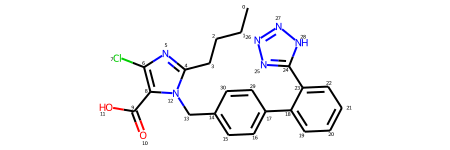

In [3]:
# Load inhibitors from smi file 
molecules = Chem.SmilesMolSupplier('./data/clique/molecules.smi',delimiter='\t',titleLine=False)
print(f"{len(molecules)} molecules")
# Visualize first molecule
molecules[0]

In [8]:
# Generate graphs for all confomers
D = [] # List containing a list of graphs for each molecule conformers
n_conformers = 10
for mol in molecules:
    mol = generate_conformers(mol, n_conformers)
    print(mol.GetNumConformers())
    graphs = []
    for cidx in range(n_conformers):
        cf_graph = conformer_graph(molecule=mol, conformer_idx=cidx, features='smarts')
        graphs.append(cf_graph)
    D.append(graphs)

10
10
10
10
10


In [15]:
len(D)

5

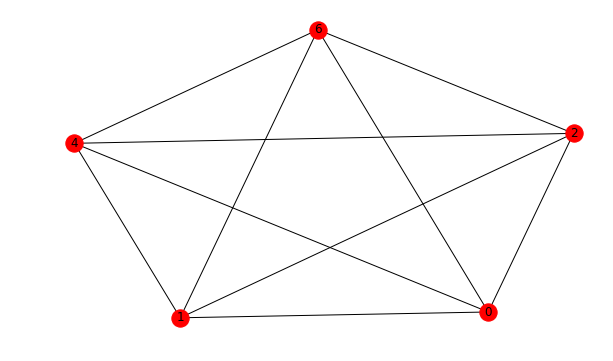

In [16]:
# Plot a sample graph
fig, ax = plt.subplots(figsize=(10,6))
nx.draw(D[0][2], with_labels=True, ax=ax)
plt.show()

In [17]:
print(D[0][0].edges(data=True), '\n')
print(D[0][1].edges(data=True), '\n')
print(D[0][2].edges(data=True), '\n')
print(D[0][3].edges(data=True), '\n')
print(D[0][4].edges(data=True), '\n')

[(0, 1, {'distance': 5}), (0, 2, {'distance': 5}), (0, 4, {'distance': 5}), (0, 6, {'distance': 6}), (1, 2, {'distance': 9}), (1, 4, {'distance': 3}), (1, 6, {'distance': 6}), (2, 4, {'distance': 8}), (2, 6, {'distance': 10}), (4, 6, {'distance': 9})] 

[(0, 1, {'distance': 5}), (0, 2, {'distance': 5}), (0, 4, {'distance': 5}), (0, 6, {'distance': 8}), (1, 2, {'distance': 7}), (1, 4, {'distance': 3}), (1, 6, {'distance': 6}), (2, 4, {'distance': 8}), (2, 6, {'distance': 11}), (4, 6, {'distance': 8})] 

[(0, 1, {'distance': 5}), (0, 2, {'distance': 5}), (0, 4, {'distance': 4}), (0, 6, {'distance': 7}), (1, 2, {'distance': 8}), (1, 4, {'distance': 4}), (1, 6, {'distance': 5}), (2, 4, {'distance': 7}), (2, 6, {'distance': 12}), (4, 6, {'distance': 8})] 

[(0, 1, {'distance': 5}), (0, 2, {'distance': 4}), (0, 4, {'distance': 4}), (0, 6, {'distance': 8}), (1, 2, {'distance': 8}), (1, 4, {'distance': 3}), (1, 6, {'distance': 5}), (2, 4, {'distance': 7}), (2, 6, {'distance': 10}), (4, 6, {'di

## Clique detection algorithm

In [28]:
def find_freq_cliques(D, supp_frac=None):
   
    _2_cliques = find_2_cliques(D) # Find all 2-cliques
    
    n_2_cliques = len(_2_cliques)
    n_molecules = len(D)
    
    # Functions to check graph isomorphism
    nm = lambda x, y: x['feat_type'] == y['feat_type'] # Match nodes feature type
    em = iso.categorical_edge_match('distance', 'distance') # Match edges distances
    
    frequency = {} # Dictionary for the frequency of each clique
    
    i = 0
    for g1_id, g1 in _2_cliques.items():
        frequency[g1_id] = 0
        
        for g2_id, g2 in _2_cliques.items():
            
            if g2_id[0] == i:
                continue #skip subgraphs of the same molecule
            
            if nx.is_isomorphic(g1, g2, node_match=nm, edge_match=em):
                frequency[g1_id] += 1
        
        i += 1
    
    # TODOs: remove unfrequent cliques, grow cliques
        
                
    return frequency
                    
def find_2_cliques(D):
    # Create a dictionary with the id of each graph as the keys
    # and the subgraphs as the values. Subgraphs represent 2-cliques.
    # An example id is 012 where the first number represents the molecule index,
    # the second number the conformer index and the third number the clique index
    _2_cliques = {}
    for i, molecule in enumerate(D): 
        for j, conformer in enumerate(molecule):
            for k, edge in enumerate(conformer.edges()):
                clique_id = str(i) + str(j) + str(k)
                clique = conformer.subgraph(list(edge))
                _2_cliques[clique_id] = clique
                
    return _2_cliques
                
f = find_freq_cliques(D)
f

{'000': 46,
 '001': 34,
 '002': 5,
 '003': 17,
 '004': 23,
 '005': 8,
 '006': 4,
 '007': 2,
 '008': 12,
 '009': 2,
 '010': 46,
 '011': 34,
 '012': 5,
 '013': 17,
 '014': 18,
 '015': 8,
 '016': 10,
 '017': 1,
 '018': 17,
 '019': 2,
 '020': 46,
 '021': 34,
 '022': 6,
 '023': 17,
 '024': 23,
 '025': 6,
 '026': 4,
 '027': 3,
 '028': 12,
 '029': 2,
 '030': 46,
 '031': 45,
 '032': 1,
 '033': 26,
 '034': 7,
 '035': 8,
 '036': 24,
 '037': 2,
 '038': 15,
 '039': 2,
 '040': 46,
 '041': 45,
 '042': 6,
 '043': 18,
 '044': 23,
 '045': 8,
 '046': 24,
 '047': 3,
 '048': 12,
 '049': 3,
 '050': 46,
 '051': 45,
 '052': 6,
 '053': 26,
 '054': 23,
 '055': 8,
 '056': 18,
 '057': 3,
 '058': 2,
 '059': 3,
 '060': 46,
 '061': 34,
 '062': 5,
 '063': 26,
 '064': 18,
 '065': 8,
 '066': 18,
 '067': 2,
 '068': 12,
 '069': 3,
 '070': 46,
 '071': 39,
 '072': 6,
 '073': 17,
 '074': 18,
 '075': 6,
 '076': 18,
 '077': 1,
 '078': 13,
 '079': 3,
 '080': 4,
 '081': 34,
 '082': 5,
 '083': 26,
 '084': 4,
 '085': 8,
 '086': 